In [1]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib ipympl
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

In [2]:
# Read in the .csv file that contains the data
med_rec = pd.read_csv("C:/Users/clown/OneDrive/Documents/MS Data Analytics/Predictive Modeling/Data/medical_clean.csv")

In [3]:
# Check for missing values
med_rec.isnull().sum().sum()

0

In [4]:
# Drop columns that contain individual indentification that isn't necessary to the model
# and rename vague column names to be more descriptive.
med_rec = med_rec.drop(['CaseOrder','Customer_id','Interaction','UID', 'City','County','Zip','State', 'TimeZone','Lat','Lng','Job'], axis=1)
med_rec = med_rec.rename({'Item1':'Timely_admission','Item2':'Timely_treatment','Item3':'Timely_visits','Item4':'Reliability',
               'Item5':'Options','Item6':'Hours_treatment','Item7':'Courteous','Item8':'Active_listening'}, axis='columns')

In [5]:
# Convert No/Yes to 0/1 in binary variables
boo = ['ReAdmis','Soft_drink','HighBlood','Stroke','Overweight','Arthritis','Diabetes','Hyperlipidemia',
       'BackPain','Anxiety','Allergic_rhinitis','Reflux_esophagitis','Asthma']
med_rec[boo] = med_rec[boo].replace({'No':False, 'Yes':True})

In [6]:
# Convert data types to category as appropriate to make analysis easier
cat = ['Area','Marital','Gender','Initial_admin','Complication_risk','Services']
med_rec[cat] = med_rec[cat].astype('category')

In [7]:
# Summary statistics for catigorical variables
med_rec.describe(include=['category'])

,Area,Marital,Gender,Initial_admin,Complication_risk,Services
count,10000,10000,10000,10000,10000,10000
unique,3,5,3,3,3,4
top,Rural,Widowed,Female,Emergency Admission,Medium,Blood Work
freq,3369,2045,5018,5060,4517,5265


In [8]:
# Summary statistics for discrete and
# ordinal variables of the data type int64
med_rec.describe(include=['int64'])

,Population,Children,Age,Doc_visits,Full_meals_eaten,vitD_supp,Timely_admission,Timely_treatment,Timely_visits,Reliability,Options,Hours_treatment,Courteous,Active_listening
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,9965.253800,2.097200,53.511700,5.012200,1.001400,0.398900,3.518800,3.506700,3.511100,3.515100,3.496900,3.522500,3.494000,3.509700
std,14824.758614,2.163659,20.638538,1.045734,1.008117,0.628505,1.031966,1.034825,1.032755,1.036282,1.030192,1.032376,1.021405,1.042312
min,0.000000,0.000000,18.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,694.750000,0.000000,36.000000,4.000000,0.000000,0.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
50%,2769.000000,1.000000,53.000000,5.000000,1.000000,0.000000,4.000000,3.000000,4.000000,4.000000,3.000000,4.000000,3.000000,3.000000
75%,13945.000000,3.000000,71.000000,6.000000,2.000000,1.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
max,122814.000000,10.000000,89.000000,9.000000,7.000000,5.000000,8.000000,7.000000,8.000000,7.000000,7.000000,7.000000,7.000000,7.000000


In [9]:
# Summary statistics for the continous variables 
med_rec.describe(include=['float64'])

,Income,VitD_levels,Initial_days,TotalCharge,Additional_charges
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,40490.495160,17.964262,34.455299,5312.172769,12934.528587
std,28521.153293,2.017231,26.309341,2180.393838,6542.601544
min,154.080000,9.806483,1.001981,1938.312067,3125.703000
25%,19598.775000,16.626439,7.896215,3179.374015,7986.487755
50%,33768.420000,17.951122,35.836244,5213.952000,11573.977735
75%,54296.402500,19.347963,61.161020,7459.699750,15626.490000
max,207249.100000,26.394449,71.981490,9180.728000,30566.070000


In [10]:
# Summary statistics for binary variables 
# to include the response variable
med_rec.describe(include=['bool'])

,ReAdmis,Soft_drink,HighBlood,Stroke,Overweight,Arthritis,Diabetes,Hyperlipidemia,BackPain,Anxiety,Allergic_rhinitis,Reflux_esophagitis,Asthma
count,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
unique,2,2,2,2,2,2,2,2,2,2,2,2,2
top,False,False,False,False,True,False,False,False,False,False,False,False,False
freq,6331,7425,5910,8007,7094,6426,7262,6628,5886,6785,6059,5865,7107


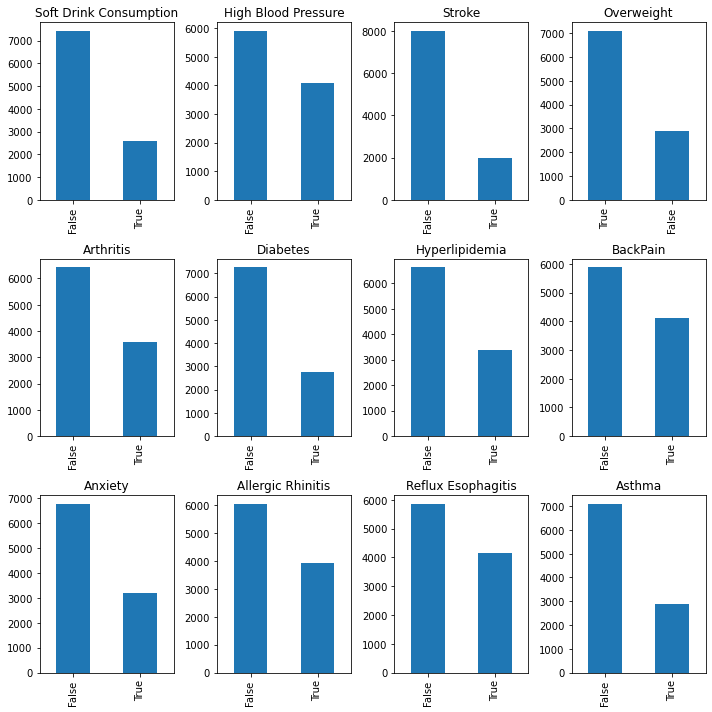

In [11]:
# Establishes a Figure with which subplots can be assigned
fig = plt.figure(figsize=(10,10))
fig_dims = (3,4)

# Creates univariate bar chart subplots for the binary independant predictors
# Seperated by row in figure
plt.subplot2grid(fig_dims,(0, 0))
med_rec['Soft_drink'].value_counts().plot(kind='bar', title='Soft Drink Consumption')
plt.subplot2grid(fig_dims,(0,1))
med_rec['HighBlood'].value_counts().plot(kind='bar',title='High Blood Pressure')
plt.subplot2grid(fig_dims,(0,2))
med_rec['Stroke'].value_counts().plot(kind='bar',title='Stroke')
plt.subplot2grid(fig_dims,(0,3))
med_rec['Overweight'].value_counts().plot(kind='bar',title='Overweight')

plt.subplot2grid(fig_dims,(1,0))
med_rec['Arthritis'].value_counts().plot(kind='bar',title='Arthritis')
plt.subplot2grid(fig_dims,(1,1))
med_rec['Diabetes'].value_counts().plot(kind='bar',title='Diabetes')
plt.subplot2grid(fig_dims,(1,2))
med_rec['Hyperlipidemia'].value_counts().plot(kind='bar',title='Hyperlipidemia')
plt.subplot2grid(fig_dims,(1,3))
med_rec['BackPain'].value_counts().plot(kind='bar',title='BackPain')

plt.subplot2grid(fig_dims,(2,0))
med_rec['Anxiety'].value_counts().plot(kind='bar',title='Anxiety')
plt.subplot2grid(fig_dims,(2,1))
med_rec['Allergic_rhinitis'].value_counts().plot(kind='bar',title='Allergic Rhinitis')
plt.subplot2grid(fig_dims,(2,2))
med_rec['Reflux_esophagitis'].value_counts().plot(kind='bar',title='Reflux Esophagitis')
plt.subplot2grid(fig_dims,(2,3))
med_rec['Asthma'].value_counts().plot(kind='bar',title='Asthma')

# Spaces out the plots and displays the figure
plt.tight_layout()
plt.show()

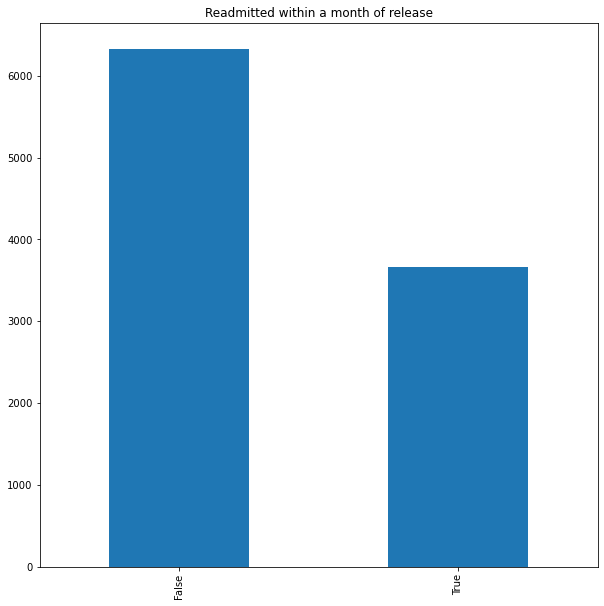

In [12]:
# Establishes a Figure with which subplots can be assigned
fig = plt.figure(figsize=(10,10))
fig_dims = (1,1)

# Shows a bar chart for the Response variable
plt.subplot2grid(fig_dims,(0,0))
med_rec['ReAdmis'].value_counts().plot(kind='bar',title='Readmitted within a month of release')
plt.show()

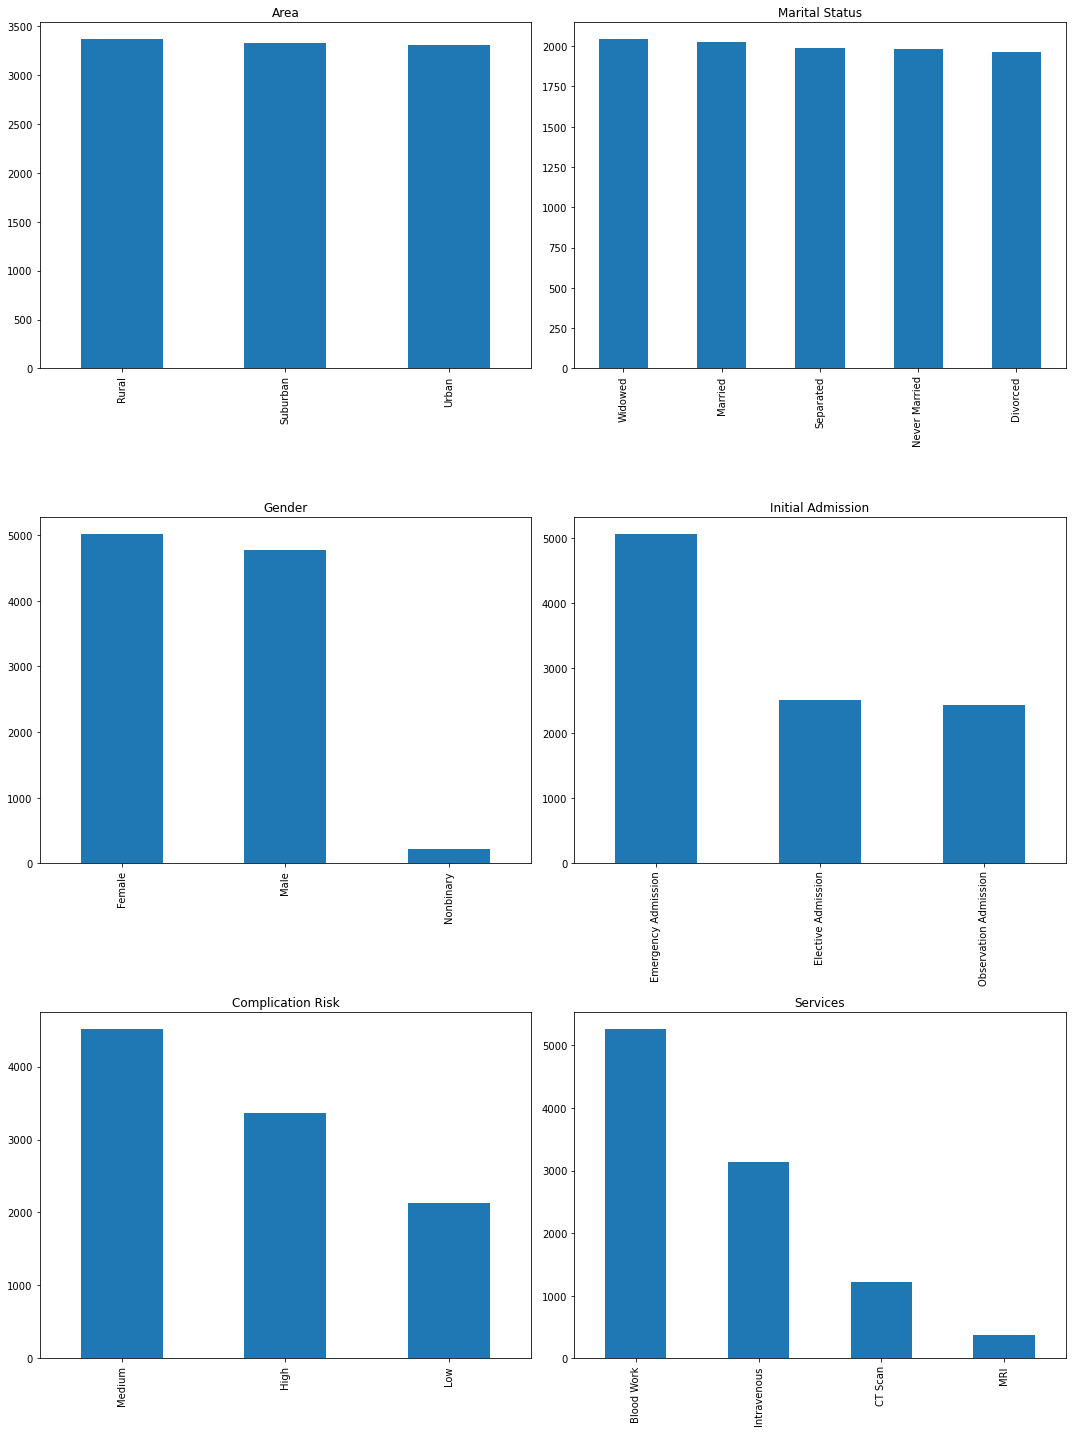

In [13]:
# Establishes a Figure with which subplots can be assigned
fig = plt.figure(figsize=(15,20))
fig_dims = (3,2)

# Creates univariate bar chart subplots for the categorical independant predictors
# Seperated by row in figure
plt.subplot2grid(fig_dims,(0, 0))
med_rec['Area'].value_counts().plot(kind='bar', title='Area')
plt.subplot2grid(fig_dims,(0, 1))
med_rec['Marital'].value_counts().plot(kind='bar', title='Marital Status')

plt.subplot2grid(fig_dims,(1, 0))
med_rec['Gender'].value_counts().plot(kind='bar', title='Gender')
plt.subplot2grid(fig_dims,(1, 1))
med_rec['Initial_admin'].value_counts().plot(kind='bar', title='Initial Admission')

plt.subplot2grid(fig_dims,(2, 0))
med_rec['Complication_risk'].value_counts().plot(kind='bar', title='Complication Risk')
plt.subplot2grid(fig_dims,(2, 1))
med_rec['Services'].value_counts().plot(kind='bar', title='Services')

# Spaces out the plots and displays the figure
plt.tight_layout()
plt.show()

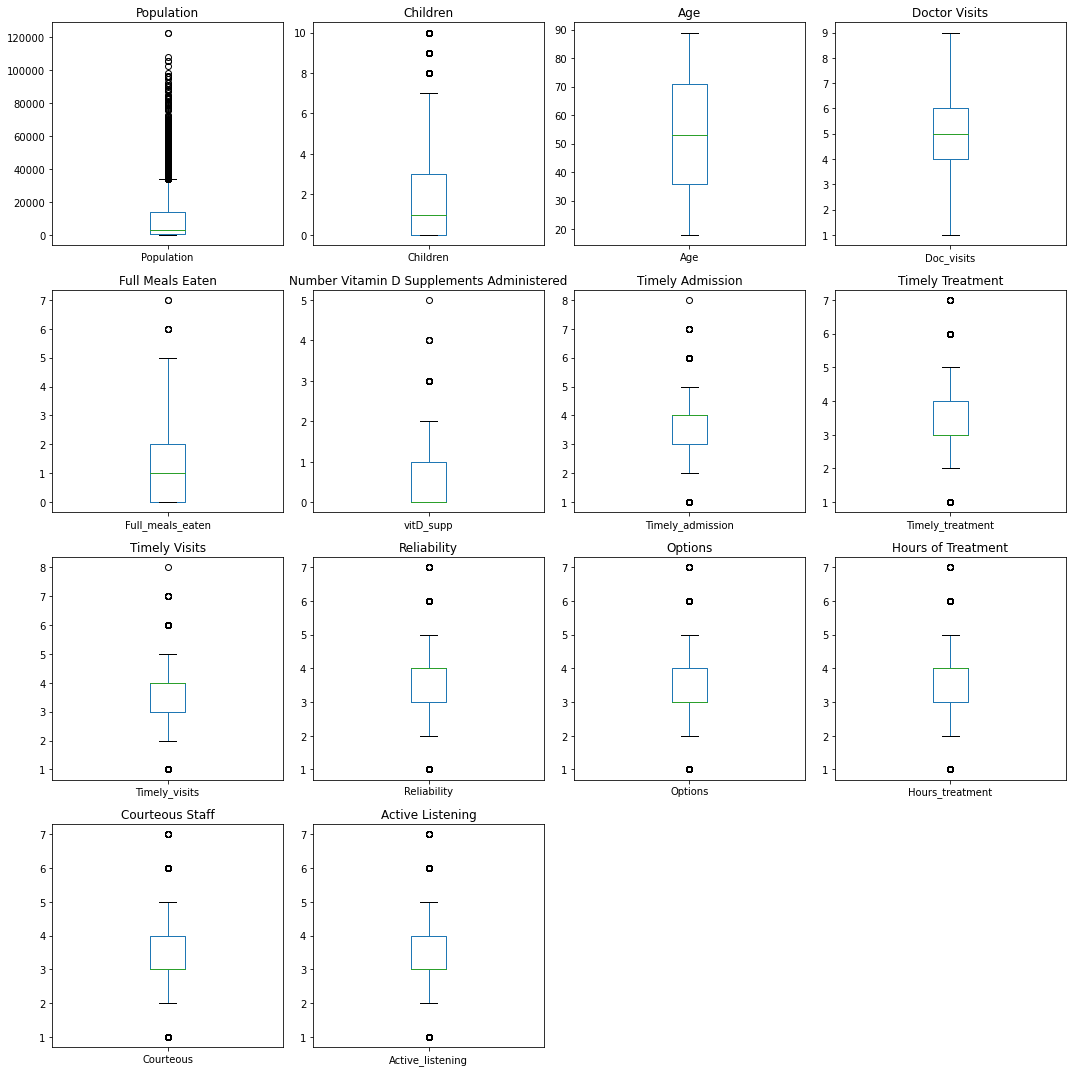

In [14]:
# Establishes a Figure with which subplots can be assigned
fig = plt.figure(figsize=(15,15))
fig_dims = (4,4)

# Creates univariate box plots of all the discrete predictor variables
# Seperated by row in figure
plt.subplot2grid(fig_dims,(0, 0))
med_rec['Population'].plot(kind='box',title='Population')
plt.subplot2grid(fig_dims,(0, 1))
med_rec['Children'].plot(kind='box', title='Children')
plt.subplot2grid(fig_dims,(0, 2))
med_rec['Age'].plot(kind='box', title='Age')
plt.subplot2grid(fig_dims,(0, 3))
med_rec['Doc_visits'].plot(kind='box', title='Doctor Visits')

plt.subplot2grid(fig_dims,(1, 0))
med_rec['Full_meals_eaten'].plot(kind='box',title='Full Meals Eaten')
plt.subplot2grid(fig_dims,(1, 1))
med_rec['vitD_supp'].plot(kind='box', title='Number Vitamin D Supplements Administered')
plt.subplot2grid(fig_dims,(1, 2))
med_rec['Timely_admission'].plot(kind='box', title='Timely Admission')
plt.subplot2grid(fig_dims,(1, 3))
med_rec['Timely_treatment'].plot(kind='box', title='Timely Treatment')

plt.subplot2grid(fig_dims,(2, 0))
med_rec['Timely_visits'].plot(kind='box',title='Timely Visits')
plt.subplot2grid(fig_dims,(2, 1))
med_rec['Reliability'].plot(kind='box', title='Reliability')
plt.subplot2grid(fig_dims,(2, 2))
med_rec['Options'].plot(kind='box', title='Options')
plt.subplot2grid(fig_dims,(2, 3))
med_rec['Hours_treatment'].plot(kind='box', title='Hours of Treatment')

plt.subplot2grid(fig_dims,(3, 0))
med_rec['Courteous'].plot(kind='box',title='Courteous Staff')
plt.subplot2grid(fig_dims,(3, 1))
med_rec['Active_listening'].plot(kind='box', title='Active Listening')

# Spaces out the plots and displays the figure
plt.tight_layout()
plt.show()

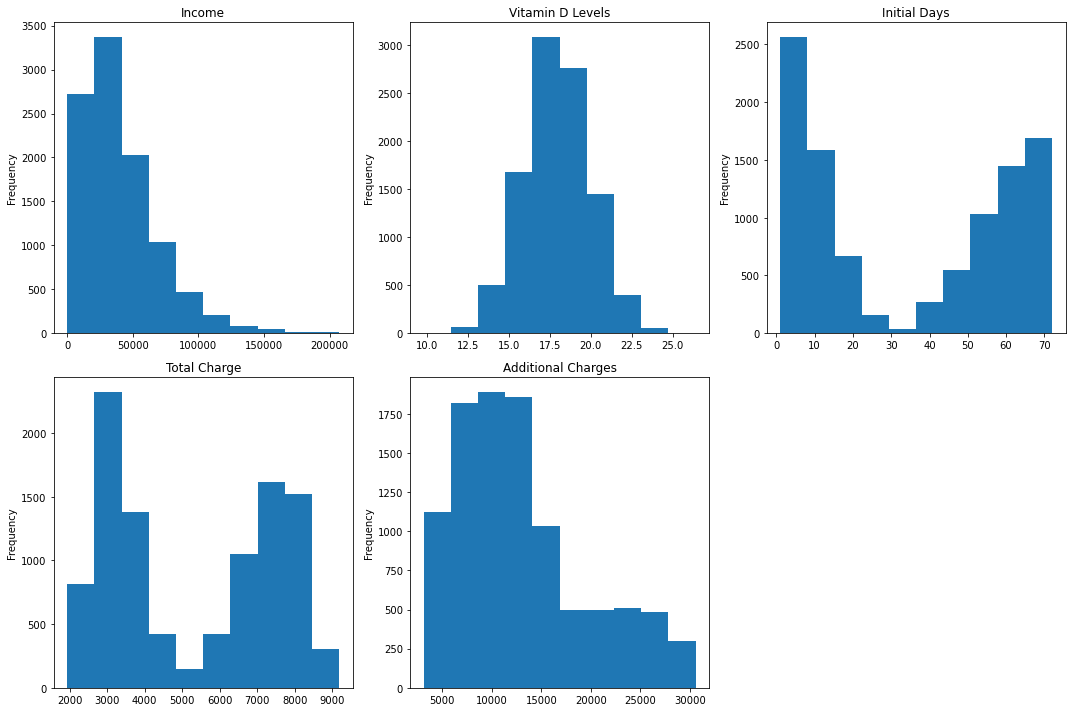

In [15]:
# Establishes a Figure with which subplots can be assigned
fig = plt.figure(figsize=(15,10))
fig_dims = (2,3)

# Creates univariate histrograms based on the continuous predictor variables
# Seperated by row in figure
plt.subplot2grid(fig_dims,(0, 0))
med_rec['Income'].plot(kind='hist',title='Income')
plt.subplot2grid(fig_dims,(0, 1))
med_rec['VitD_levels'].plot(kind='hist', title='Vitamin D Levels')
plt.subplot2grid(fig_dims,(0, 2))
med_rec['Initial_days'].plot(kind='hist', title='Initial Days')

plt.subplot2grid(fig_dims,(1, 0))
med_rec['TotalCharge'].plot(kind='hist', title='Total Charge')
plt.subplot2grid(fig_dims,(1, 1))
med_rec['Additional_charges'].plot(kind='hist', title='Additional Charges')

# Spaces out the plots and displays the figure
plt.tight_layout()
plt.show()

<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5

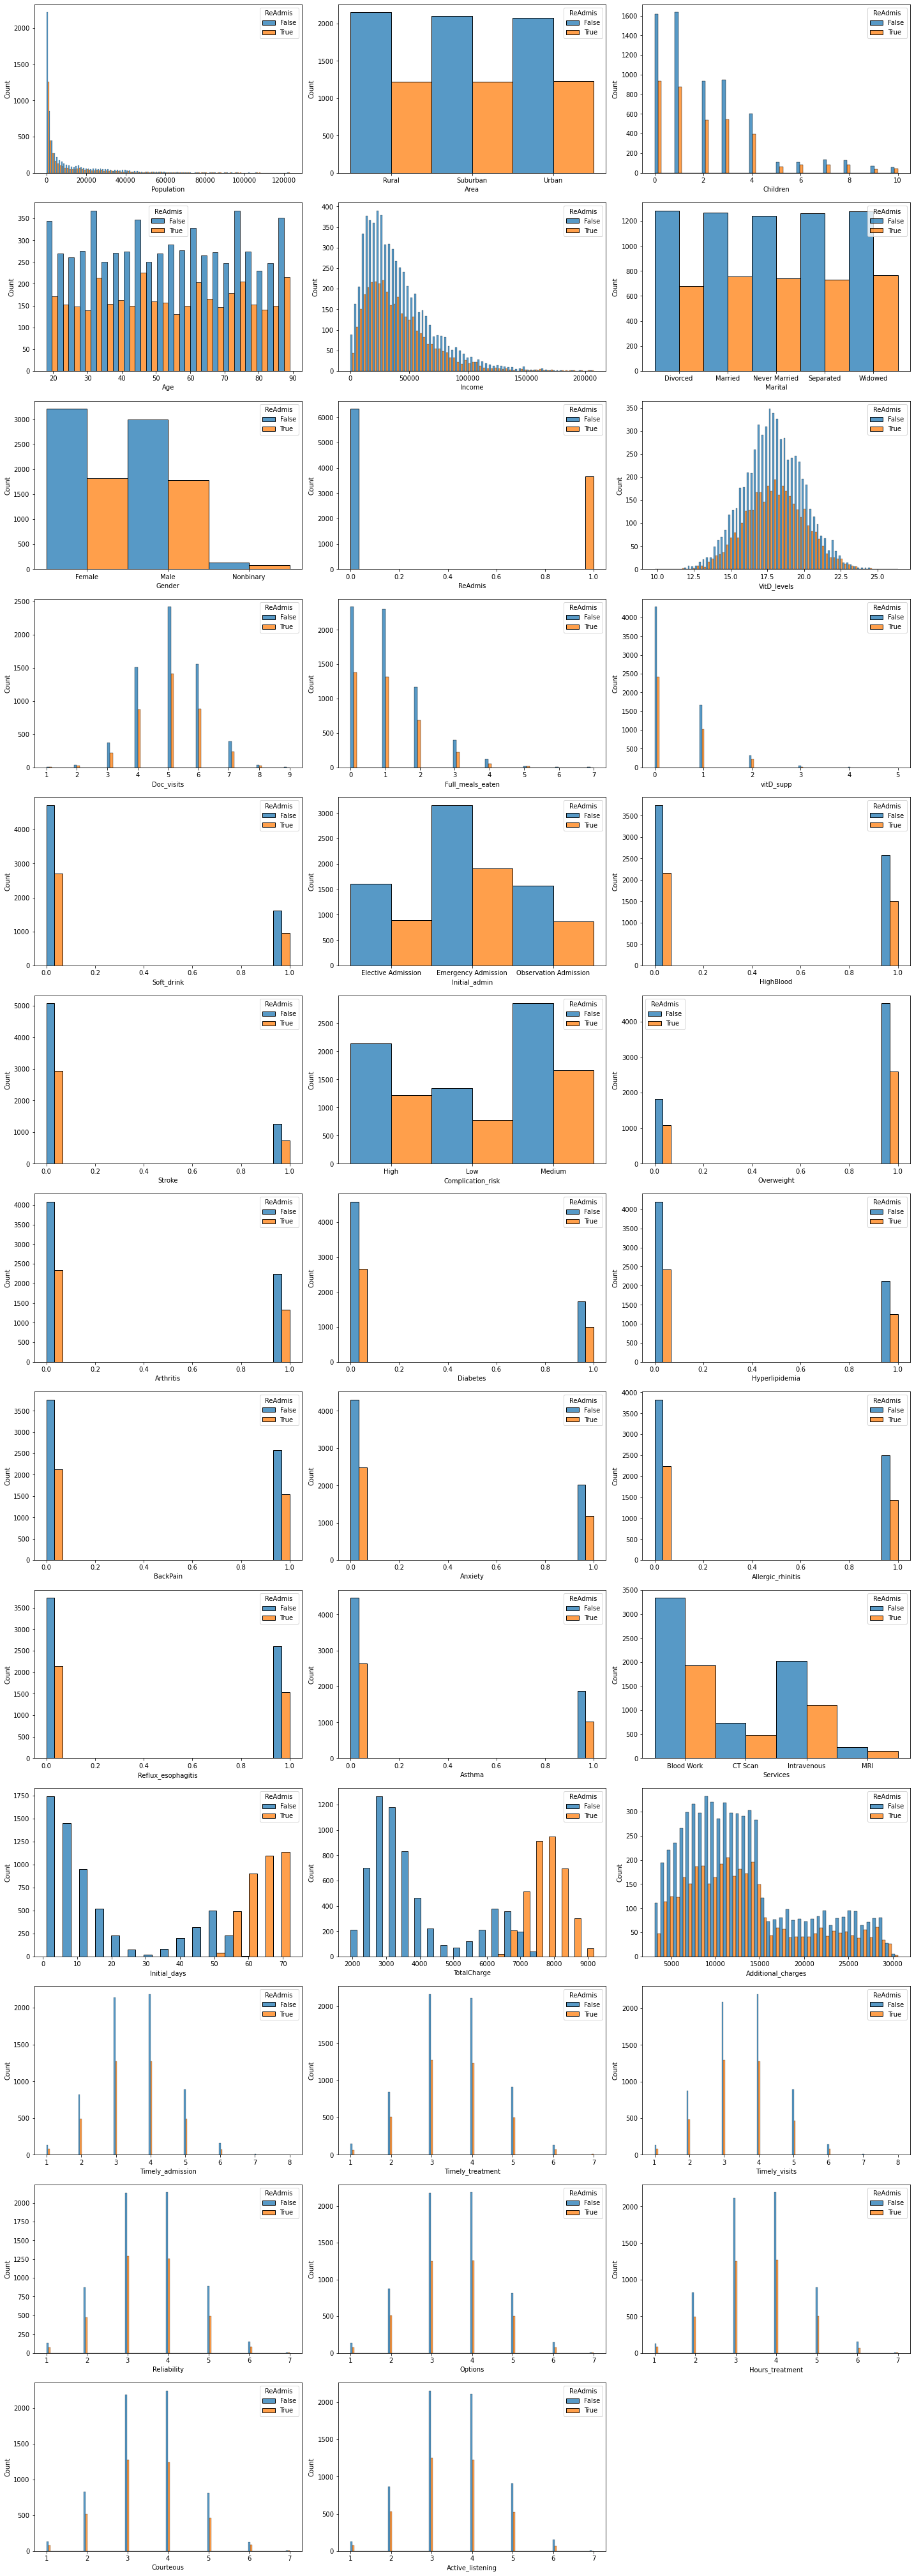

In [16]:
# Establishes a Figure with which subplots can be assigned
fig = plt.figure(figsize=(20,60))
col_max=14
row_max=3
fig_dims = (col_max,row_max)

# For loop that iterates over every independent variable producing a graph
# that is split on the dependent variable.
i = 0
j = 0
for col, row in med_rec.iteritems():
    plt.subplot2grid(fig_dims,(i, j))
    sns.histplot(x=med_rec[col], hue=med_rec.ReAdmis, multiple='dodge')
    j+=1
    if (j == row_max):
        j=0
        i+=1
    if (i == col_max):
        break
# Spaces out the plots and displays the figure
plt.tight_layout()
plt.show()

In [17]:
# Create Dummy Variables for all categorical independent variables
med_rec_dummies=pd.get_dummies(med_rec, drop_first=True)

In [18]:
# Split the data into dependent and independent variables
dependent = med_rec_dummies.ReAdmis
independent = med_rec_dummies.drop(columns=['ReAdmis'])

In [19]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = independent.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(independent.astype(float).values, i)
                          for i in range(len(independent.columns))]

In [20]:
# Creates a list of independent variables that have excessive
# VIF numbers, then drops them from the data
feature_list = []
for feature, VIF in zip(vif_data.feature, vif_data.VIF):
    if VIF > 10:
        print("Variable: ",feature," VIF: ",VIF)
        feature_list.append(feature)
for item in feature_list:
    if item in independent:
        independent = independent.drop(columns=item)

Variable:  HighBlood  VIF:  13.951439225480703
Variable:  Initial_days  VIF:  543.2590884150784
Variable:  TotalCharge  VIF:  1394.8419163056499
Variable:  Additional_charges  VIF:  16.321394084671535


In [21]:
# Write the prepared data to csv file
med_rec_prepared = med_rec.drop(['HighBlood','Initial_days','TotalCharge','Additional_charges'],axis='columns')
med_rec.to_csv("C:/Users/clown/OneDrive/Documents/MS Data Analytics/Predictive Modeling/Data/medical_prepared.csv",index=False)

In [22]:
# Split into train and test data
x_train, x_test, y_train, y_test = train_test_split(independent, dependent, test_size = 0.3)

In [23]:
# Create the model and print the summary
model = sm.Logit(y_train, x_train.astype(float))
result = model.fit(disp=0)
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:                ReAdmis   No. Observations:                 7000
Model:                          Logit   Df Residuals:                     6958
Method:                           MLE   Df Model:                           41
Date:                Thu, 28 Oct 2021   Pseudo R-squ.:                0.004180
Time:                        15:29:12   Log-Likelihood:                -4572.3
converged:                       True   LL-Null:                       -4591.5
Covariance Type:            nonrobust   LLR p-value:                    0.5873
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Population                           1.845e-06   1.66e-06      1.109      0.267   -1.41e-06     5.1e-06
Children                                0.0151      0.01

Test accuracy =  0.6276666666666667


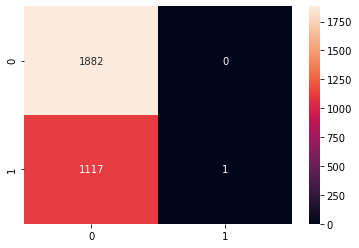

In [24]:
# Creates a list of predictions
yhat = result.predict(x_test.astype(float))
prediction = list(map(round, yhat))

# confusion matrix
cm = metrics.confusion_matrix(y_test, prediction)
sns.heatmap(cm, annot=True, fmt='0000')

# accuracy score of the model
print('Test accuracy = ', metrics.accuracy_score(y_test, prediction))

In [25]:
# Global variables to perfrom checks
sig_features = []
highest = 'no'
last_highest = 'yes'
aic_check = independent
current_aic = result.aic


# Removes features with the highest p-values, then evaluates the AIC
# in order to determine if the feature helped predictability
elim_result = sm.Logit(dependent, independent.astype(float)).fit(disp=0)
min_aic = elim_result.aic
while highest != last_highest:
    max_pvalue = 0.05
    last_highest = highest
    
    if min_aic > current_aic and highest != 'no':
        min_aic = current_aic
        aic_check = aic_check.drop(columns=highest)
    elif min_aic < current_aic and highest != 'no':
        sig_features.append(highest)
        independent = aic_check
    
    for feature, pvalue in zip(independent.columns, elim_result.pvalues):
        if pvalue > max_pvalue and feature not in sig_features:
            max_pvalue = pvalue
            highest = feature
    if highest != last_highest:
        independent = independent.drop(columns=highest)
        elim_result = sm.Logit(dependent, independent.astype(float)).fit(disp=0)
        current_aic = elim_result.aic

independent.columns

Index(['Population', 'Children', 'Income', 'VitD_levels', 'Asthma',
       'Timely_admission', 'Active_listening',
       'Initial_admin_Emergency Admission', 'Services_CT Scan',
       'Services_Intravenous'],
      dtype='object')

In [26]:
# Split into train and test data
x_train, x_test, y_train, y_test = train_test_split(independent, dependent, test_size = 0.3)

model = sm.Logit(y_train, x_train.astype(float))
result = model.fit(disp=0)
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:                ReAdmis   No. Observations:                 7000
Model:                          Logit   Df Residuals:                     6990
Method:                           MLE   Df Model:                            9
Date:                Thu, 28 Oct 2021   Pseudo R-squ.:                0.004513
Time:                        15:33:01   Log-Likelihood:                -4581.7
converged:                       True   LL-Null:                       -4602.5
Covariance Type:            nonrobust   LLR p-value:                 3.984e-06
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Population                         2.853e-06   1.65e-06      1.727      0.084   -3.84e-07    6.09e-06
Children                              0.0258      0.011      2

Test accuracy =  0.634


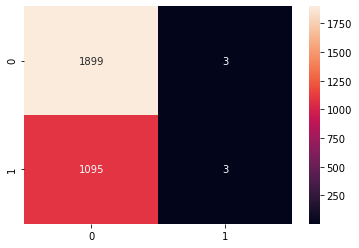

In [27]:
# Creates a list of predictions
yhat = result.predict(x_test.astype(float))
prediction = list(map(round, yhat))

# confusion matrix
cm = metrics.confusion_matrix(y_true=y_test, y_pred=prediction)
sns.heatmap(cm, annot=True, fmt='0000')
 
# accuracy score of the model
print('Test accuracy = ', metrics.accuracy_score(y_true=y_test, y_pred=prediction))

In [28]:
result.params

Population                           0.000003
Children                             0.025809
Income                              -0.000001
VitD_levels                         -0.011081
Asthma                              -0.117004
Timely_admission                    -0.058126
Active_listening                    -0.048203
Initial_admin_Emergency Admission    0.106772
Services_CT Scan                     0.172963
Services_Intravenous                -0.148170
dtype: float64

In [29]:
# Collect the final independent variables, and the dependent variable together and
# Write the final cleaned data to a csv file
med_final = med_rec[['Population','Children','Income','ReAdmis','VitD_levels','Asthma','Timely_admission','Active_listening',
                    'Initial_admin','Services']]

med_final.to_csv("C:/Users/clown/OneDrive/Documents/MS Data Analytics/Predictive Modeling/Data/medical_final.csv",index=False)